In [1]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(GenomicRanges))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(Signac))
suppressPackageStartupMessages(library(EnsDb.Hsapiens.v86))
suppressPackageStartupMessages(library(EnsDb.Mmusculus.v79))

In [2]:
peaks_path <- "/fs/nexus-projects/scATAC-seq/piscem/map_output/8k_mouse_cortex_ATACv2_nextgem_Chromium_Controller_fastqs/k_23/m_15/thr=0.7/macs2_peaks.narrowPeak"
mapping_path <- "/fs/nexus-projects/scATAC-seq/piscem/map_output/8k_mouse_cortex_ATACv2_nextgem_Chromium_Controller_fastqs/k_23/m_15/thr=0.7/map_sorted.bed.gz"
data_name <- "PBMC"
method_name <- "piscem"
# genome <- "mm10"
org <- "mm10"

In [7]:
# out_path <- ""
# mapping_cells <- read_tsv(mapping_path, 
#     col_names=c("chr","start","stop","cell", "support"), 
#     col_types=c("-","-","-","-","-"),
#     col_select="cell") %>% 
#     pull(cell) %>% 
#     unique()

# names(x = mapping_cells) <- paste(data_name, method_name, mapping_cells, sep="_")

# mapping_frags <- CreateFragmentObject(path = mapping_path, cells = mapping_cells, max.lines=NULL)

# p <- as.data.frame(read.table(peaks_path,header=F,sep="\t"))
# p <- p[,c(1:3)]
# colnames(p) <- c("chr","start","stop")
# peaks <- suppressPackageStartupMessages(makeGRangesFromDataFrame(p))

# mat <- FeatureMatrix(
#   fragments = mapping_frags,
#   features = peaks,
#   process_n = 20000,
#   sep = c("-", "-"),
#   verbose = TRUE
# )

mapping_assay <- CreateChromatinAssay(mat, fragments = mapping_frags, 
    genome = org, min.features = 500)
seurat_ob <- CreateSeuratObject(mapping_assay, assay = "peaks")
seurat_ob$Sample <- paste(data_name, method_name, sep = "_")

In [5]:
annotations <- if(org=="hg38") GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86) else GetGRangesFromEnsDb(ensdb = EnsDb.Mmusculus.v79)
seqlevelsStyle(annotations) <- 'UCSC'

genome(annotations) <- org


Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

In [8]:
fragmentInfo <- CountFragments(mapping_path)
rownames(fragmentInfo) <- paste0(seurat_ob$Sample, "_", fragmentInfo$CB)

# Attach cell metadata to seurat object
seurat_ob$fragments <- fragmentInfo[colnames(seurat_ob), "frequency_count"]
seurat_ob$mononucleosomal <- fragmentInfo[colnames(seurat_ob), "mononucleosomal"]
seurat_ob$nucleosome_free <- fragmentInfo[colnames(seurat_ob), "nucleosome_free"]
seurat_ob$reads_count <- fragmentInfo[colnames(seurat_ob), "reads_count"]

# Calculate FRiP
seurat_ob <- FRiP(
  object = seurat_ob,
  assay = 'peaks',
  total.fragments = "fragments"
)

Calculating fraction of reads in peaks per cell



In [9]:
seurat_ob$blacklist_fraction <- if (org=="hg38"){
      FractionCountsInRegion(
      object = seurat_ob, 
      assay = 'peaks',
      regions = blacklist_hg38
        )  
    } else {
        FractionCountsInRegion(
          object = seurat_ob, 
          assay = 'peaks',
          regions = blacklist_mm10
        )
    }

# Compute nucleosome signal score per cell
seurat_ob <- NucleosomeSignal(seurat_ob)

# Compute TSS enrichment
Annotation(seurat_ob) <- annotations
seurat_ob <- TSSEnrichment(seurat_ob, fast=TRUE)

Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



In [10]:
seurat_ob_sub <- subset(x = seurat_ob,
        subset = nCount_peaks > 1000 &
        nCount_peaks < 100000 &
        FRiP > 0.15 &
        blacklist_fraction < 0.05 &
        nucleosome_signal < 4 &
        TSS.enrichment > 2
        )

seurat_ob_sub <- RunTFIDF(seurat_ob)
seurat_ob_sub <- FindTopFeatures(seurat_ob_sub, min.cutoff = 'q0')
seurat_ob_sub <- RunSVD(seurat_ob_sub)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings



In [11]:
seurat_ob_sub <- RunUMAP(object = seurat_ob_sub, reduction = 'lsi', dims = 2:30)
seurat_ob_sub <- FindNeighbors(object = seurat_ob_sub, reduction = 'lsi', dims = 2:30)
seurat_ob_sub <- FindClusters(object = seurat_ob_sub, verbose = FALSE, algorithm = 3)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
00:06:53 UMAP embedding parameters a = 0.9922 b = 1.112

00:06:53 Read 7800 rows and found 29 numeric columns

00:06:53 Using Annoy for neighbor search, n_neighbors = 30

00:06:53 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

00:06:53 Writing NN index file to temp file /tmp/RtmpfJDJ2A/file269b9413148653

00:06:53 Searching Annoy index using 1 thread, search_k = 3000

00:06:55 Annoy recall = 100%

00:06:56 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors

In [16]:
seurat_ob_sub$nucleosome_group <- ifelse(seurat_ob$nucleosome_signal > 4, 'NS > 4', 'NS < 4')

Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_bin()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range (`geom_bar()`)."


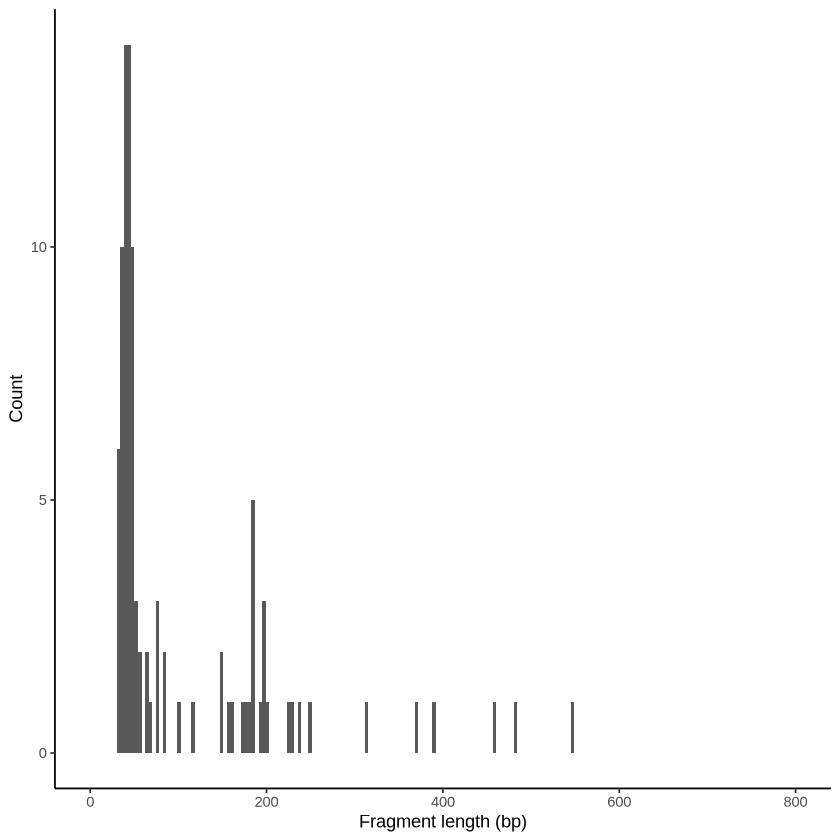

In [30]:
FragmentHistogram(object = seurat_ob, group.by = 'nucleosome_group', region = "chrY-1-2000000")

In [14]:
FragmentHistogram

function (object, assay = NULL, region = "chr1-1-2000000", group.by = NULL, 
    cells = NULL, log.scale = FALSE, ...) 
{
    cells <- SetIfNull(x = cells, y = colnames(x = object))
    assay <- SetIfNull(x = assay, y = DefaultAssay(object = object))
    if (!inherits(x = object[[assay]], what = "ChromatinAssay")) {
        stop("The requested assay is not a ChromatinAssay.")
    }
    reads <- MultiGetReadsInRegion(object = object, assay = assay, 
        region = region, cells = cells, verbose = FALSE, ...)
    if (is.null(x = group.by)) {
        groups <- Idents(object = object)
    }
    else {
        md <- object[[]]
        groups <- object[[group.by]]
        groups <- groups[, 1]
        names(x = groups) <- rownames(x = md)
    }
    reads$group <- groups[reads$cell]
    if (length(x = unique(x = reads$group)) == 1) {
        p <- ggplot(data = reads, aes(length)) + geom_histogram(bins = 200)
    }
    else {
        p <- ggplot(data = reads, mapping = aes(x = length, fill = group)) + 
            geom_histogram(bins = 200) + facet_wrap(~group, scales = "free_y")
    }
    p <- p + xlim(c(0, 800)) + theme_classic() + theme(legend.position = "none", 
        strip.background = element_blank()) + xlab("Fragment length (bp)") + 
        ylab("Count")
    if (log.scale) {
        p <- p + scale_y_log10()
    }
    return(p)
}
<bytecode: 0x55c2d321d9f8>
<environment: namespace:Signac>

In [27]:
cells <- Signac:::SetIfNull(x = NULL, y = colnames(x = seurat_ob))
assay <- Signac:::SetIfNull(x = NULL, y = DefaultAssay(object = seurat_ob))
reads <- Signac:::MultiGetReadsInRegion(object = seurat_ob, assay = assay, 
        region = NULL, cells = cells, verbose = FALSE)

ERROR: [1m[33mError[39m in `separate()`:[22m
[33m![39m Can't extract columns that don't exist.
[31m✖[39m Column `ranges` doesn't exist.


In [28]:
Signac:::MultiGetReadsInRegion

function (object, region, fragment.list = NULL, assay = NULL, 
    ...) 
{
    if (inherits(x = object, what = "Seurat")) {
        assay <- SetIfNull(x = assay, y = DefaultAssay(object = object))
        object <- object[[assay]]
    }
    fragment.list <- SetIfNull(x = fragment.list, y = Fragments(object = object))
    if (length(x = fragment.list) == 0) {
        stop("No fragment files found")
    }
    res <- data.frame()
    for (i in seq_along(along.with = fragment.list)) {
        tbx.path <- GetFragmentData(object = fragment.list[[i]], 
            slot = "path")
        cellmap <- GetFragmentData(object = fragment.list[[i]], 
            slot = "cells")
        tabix.file <- TabixFile(file = tbx.path, index = GetIndexFile(fragment = tbx.path, 
            verbose = FALSE))
        open(con = tabix.file)
        reads <- GetReadsInRegion(cellmap = cellmap, region = region, 
            tabix.file = tabix.file, ...)
        res <- rbind(res, reads)
        close(con = tabix.file)
    }
    return(res)
}
<bytecode: 0x55c2d31c1fb0>
<environment: namespace:Signac>